In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-12-14 11:59:02.438582: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-14 11:59:02.446177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734188342.453596   71577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734188342.455639   71577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 11:59:02.464223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1. Exploración y preprocesamiento de datos:
- Carga y explora el dataset, identificando las variables relacionadas con los datos sensoriales. Este conjunto de datos incluye lecturas de aceleración en los ejes X, Y y Z mientras los sujetos realizan actividades como caminar, correr, y subir escaleras.
- Asegúrate de manejar cualquier valor nulo, normalizando las lecturas sensoriales para mejorar el rendimiento del análisis y el modelado posterior.

In [2]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


Contamos con 6 Categorias en nuestro target

In [3]:
pd.unique(df['Activity'])

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

Ningun dato nulo

In [42]:
df.isnull().sum()

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

In [25]:
df.describe

<bound method NDFrame.describe of       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0              0.288585          -0.020294          -0.132905   
1              0.278419          -0.016411          -0.123520   
2              0.279653          -0.019467          -0.113462   
3              0.279174          -0.026201          -0.123283   
4              0.276629          -0.016570          -0.115362   
...                 ...                ...                ...   
7347           0.299665          -0.057193          -0.181233   
7348           0.273853          -0.007749          -0.147468   
7349           0.273387          -0.017011          -0.045022   
7350           0.289654          -0.018843          -0.158281   
7351           0.351503          -0.012423          -0.203867   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0            -0.995279         -0.983111         -0.913526         -0.995112   
1            -0.998245   

In [4]:
df.shape

(7352, 563)

In [5]:
df.dtypes

tBodyAcc-mean()-X       float64
tBodyAcc-mean()-Y       float64
tBodyAcc-mean()-Z       float64
tBodyAcc-std()-X        float64
tBodyAcc-std()-Y        float64
                         ...   
angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
Length: 563, dtype: object

In [6]:
df['Activity'] = df['Activity'].astype('category')

Voy a Codificar la columna Activity con el LabelEncoder y normalizar los datos.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Activity', axis=1))


In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])


In [9]:
from sklearn.model_selection import train_test_split

X = X_scaled
y = df['Activity']

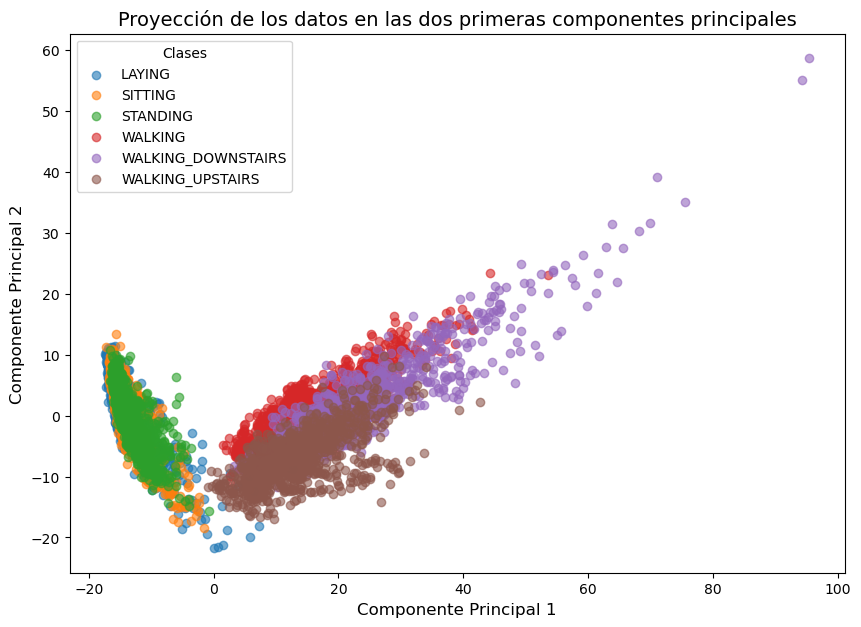

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convertir y a categorías si no lo está
classes = np.unique(y)

# Crear la figura
plt.figure(figsize=(10, 7))

# Dibujar los puntos con colores diferentes para cada clase
for class_value in classes:
    mask = (y == class_value)  # Filtrar puntos que pertenecen a la clase actual
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1], 
        label=label_encoder.classes_[class_value],  # Etiqueta para la leyenda
        alpha=0.6
    )

# Agregar título y etiquetas de ejes
plt.title('Proyección de los datos en las dos primeras componentes principales', fontsize=14)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)

# Agregar la leyenda
plt.legend(title="Clases", loc="best", fontsize=10)

# Mostrar el gráfico
plt.show()


Vemos como en las las dos primeras componentes ya nos ayudan a explicar gran parte de la varianza. Ya se pueden ver separadas varias de las clases

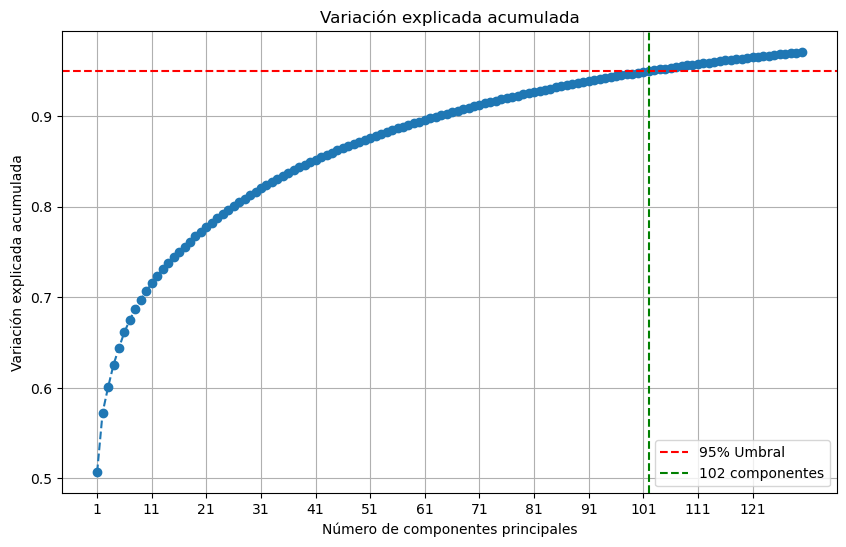

Variación explicada acumulada:
Componente 1: 50.69%
Componente 2: 57.26%
Componente 3: 60.06%
Componente 4: 62.56%
Componente 5: 64.45%
Componente 6: 66.17%
Componente 7: 67.54%
Componente 8: 68.74%
Componente 9: 69.74%
Componente 10: 70.70%
Componente 11: 71.56%
Componente 12: 72.36%
Componente 13: 73.13%
Componente 14: 73.78%
Componente 15: 74.41%
Componente 16: 75.01%
Componente 17: 75.59%
Componente 18: 76.17%
Componente 19: 76.74%
Componente 20: 77.26%
Componente 21: 77.76%
Componente 22: 78.25%
Componente 23: 78.73%
Componente 24: 79.20%
Componente 25: 79.65%
Componente 26: 80.07%
Componente 27: 80.49%
Componente 28: 80.90%
Componente 29: 81.29%
Componente 30: 81.68%
Componente 31: 82.04%
Componente 32: 82.39%
Componente 33: 82.74%
Componente 34: 83.08%
Componente 35: 83.41%
Componente 36: 83.74%
Componente 37: 84.06%
Componente 38: 84.36%
Componente 39: 84.64%
Componente 40: 84.93%
Componente 41: 85.20%
Componente 42: 85.47%
Componente 43: 85.73%
Componente 44: 85.99%
Componente

In [11]:
import numpy as np
pca_full = PCA(n_components=130)
pca_full.fit(X_scaled)

# Variación explicada acumulada
explained_variance_cumulative = np.cumsum(pca_full.explained_variance_ratio_)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(range(1, 131), explained_variance_cumulative, marker='o', linestyle='--')
plt.title('Variación explicada acumulada')
plt.xlabel('Número de componentes principales')
plt.ylabel('Variación explicada acumulada')
plt.xticks(range(1, 131, 10))  # Mostrar solo cada dos componentes para claridad
plt.grid(True)

# Marcar el umbral del 95% como referencia
threshold = 0.95
optimal_components = np.argmax(explained_variance_cumulative >= threshold) + 1
plt.axhline(y=threshold, color='r', linestyle='--', label=f'95% Umbral')
plt.axvline(x=optimal_components, color='g', linestyle='--', label=f'{optimal_components} componentes')

plt.legend()
plt.show()

# Mostrar la varianza explicada acumulada para cada componente
print("Variación explicada acumulada:")
for i, variance in enumerate(explained_variance_cumulative, 1):
    print(f"Componente {i}: {variance:.2%}")

Para la reduccion de dimensionalidad voy a usar el PCA y mantener los primeros 102 componentes que nos explican el 95% de la varianza.

In [12]:
pca_full = PCA(n_components=0.95)  # Mantén el 95% de la varianza
X_pca_full = pca_full.fit_transform(X_scaled)
print(f"Número de componentes para explicar el 95% de la varianza: {pca_full.n_components_}")


Número de componentes para explicar el 95% de la varianza: 102


3. Modelado con MLP:
- Desarrolla un modelo MLP para predecir el tipo de actividad física realizada por los usuarios basándose en los datos sensoriales.
- Divide el dataset en conjuntos de entrenamiento y prueba, asegurándote de que las distintas actividades estén bien representadas en ambos conjuntos.
- Configura la arquitectura del MLP, utilizando al menos dos capas ocultas, y ajusta hiperparámetros como el tamaño del batch, el número de épocas y la tasa de aprendizaje.

Defino el  modelo con 2 capas ocultas una tasa de aprendizaje de 0.001 y luego lo entreno con 50 epochs y batch size de 32

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
X = X_pca_full
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Arquitectura del MLP
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Primera capa oculta
    Dense(64, activation='relu'),                                   # Segunda capa oculta
    Dense(6, activation='softmax')               # Capa de salida
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


/home/andy/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1734188345.900429   71577 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        13,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,830 (85.27 KB)

 Trainable params: 21,830 (85.27 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    verbose=1)


Epoch 1/50


I0000 00:00:1734188347.237812   71694 service.cc:148] XLA service 0x7faaa0017030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734188347.237849   71694 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-14 11:59:07.246431: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734188347.285993   71694 cuda_dnn.cc:529] Loaded cuDNN version 90300


 90/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6381 - loss: 0.9525

I0000 00:00:1734188348.110308   71694 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7130 - loss: 0.7627 - val_accuracy: 0.9405 - val_loss: 0.1552
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - loss: 0.1123 - val_accuracy: 0.9652 - val_loss: 0.0993
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9704 - loss: 0.0796 - val_accuracy: 0.9669 - val_loss: 0.0878
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.0582 - val_accuracy: 0.9711 - val_loss: 0.0716
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0428 - val_accuracy: 0.9703 - val_loss: 0.0755
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0336 - val_accuracy: 0.9779 - val_loss: 0.0621
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0270 - val_accuracy: 0.9669 - val_loss: 0.0830
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0244 - val_accuracy: 0.9745 - val_

Revisamos que las clases esten balanceadas en los dos conjuntos

In [28]:
# Revisar balance en el conjunto de entrenamiento
train_classes, train_counts = np.unique(y_train, return_counts=True)
train_balance = pd.DataFrame({
    "Clase": train_classes,
    "Frecuencia (Train)": train_counts,
    "Porcentaje (Train)": (train_counts / len(y_train)) * 100
})

# Revisar balance en el conjunto de prueba
test_classes, test_counts = np.unique(y_test, return_counts=True)
test_balance = pd.DataFrame({
    "Clase": test_classes,
    "Frecuencia (Test)": test_counts,
    "Porcentaje (Test)": (test_counts / len(y_test)) * 100
})

# Mostrar resultados
print("Balance de clases en el conjunto de entrenamiento:")
print(train_balance)
print("\nBalance de clases en el conjunto de prueba:")
print(test_balance)

Balance de clases en el conjunto de entrenamiento:
   Clase  Frecuencia (Train)  Porcentaje (Train)
0      0                1127           19.163408
1      1                1024           17.412005
2      2                1098           18.670294
3      3                 979           16.646829
4      4                 780           13.263051
5      5                 873           14.844414

Balance de clases en el conjunto de prueba:
   Clase  Frecuencia (Test)  Porcentaje (Test)
0      0                280          19.034670
1      1                262          17.811013
2      2                276          18.762746
3      3                247          16.791298
4      4                206          14.004079
5      5                200          13.596193


4. Evaluación del modelo:
- Evalúa el rendimiento del MLP utilizando métricas como la precisión, el recall, el F1-score y la matriz de confusión. Discute si el modelo es capaz de predecir correctamente las distintas actividades físicas.
- Visualiza las curvas de aprendizaje, mostrando cómo evoluciona la pérdida y la precisión a lo largo del entrenamiento.

Voy a generar el reporte de la clasificacion y la matriz de confusion

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       280
           SITTING       0.92      0.94      0.93       262
          STANDING       0.94      0.93      0.93       276
           WALKING       0.99      1.00      0.99       247
WALKING_DOWNSTAIRS       0.98      0.99      0.98       206
  WALKING_UPSTAIRS       0.98      0.97      0.98       200

          accuracy                           0.97      1471
         macro avg       0.97      0.97      0.97      1471
      weighted avg       0.97      0.97      0.97      1471



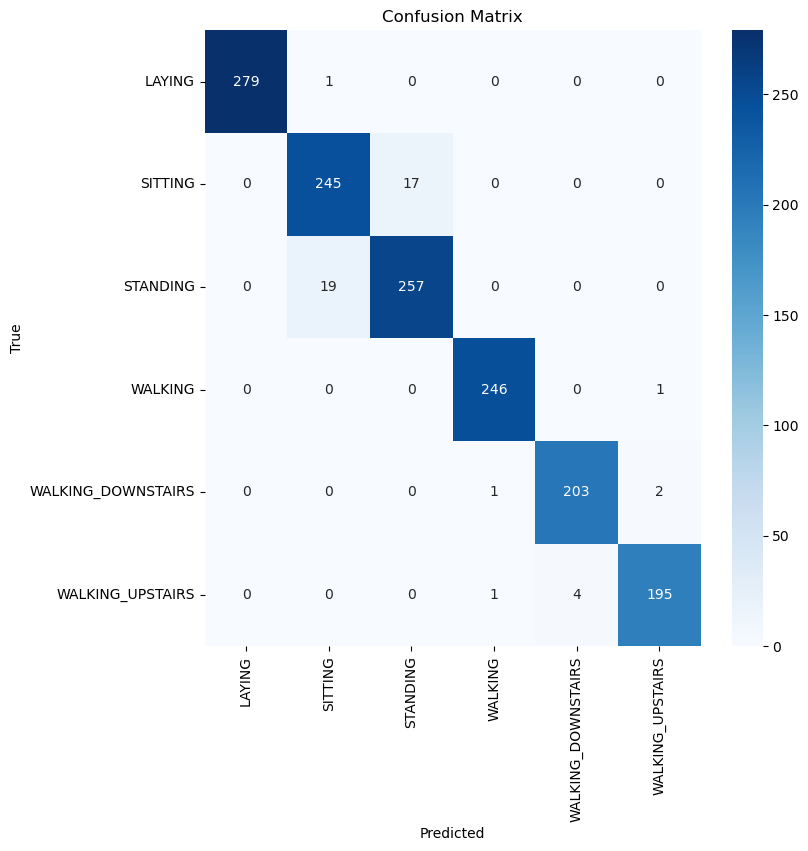

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluación en el conjunto de prueba
y_pred = np.argmax(model.predict(X_test), axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Vemos que la mayor confusion ocurre entre Sitting y Standing, lo que es de esperarse por su similaridad para el acelerometro

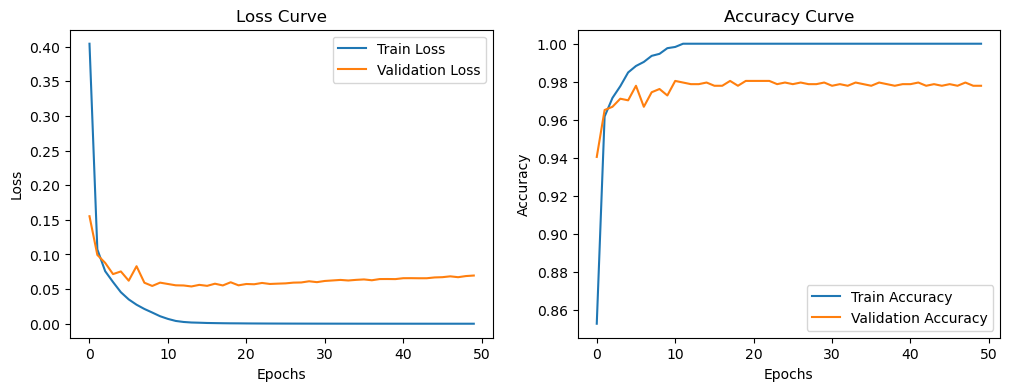

In [16]:
# Curvas de aprendizaje
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


De la curva de perdida vemos que en las primeras 10 epochs se aproxima rapidamente a 0 lo que nos indica que el modelo esta ajustandose bien al conjunto de entrenamiento, pero nuestra perdida en validacion se estabiliza converge rapidamente a un valor y luego va creciendo lentamente, lo que nos podria indicar un overfitting.
- Para prevenir este overfitting se podria implementar alguna tecnica de regularizacion como Dropout o L2. O incluso early stopping

Aqui voy a entrenar el modelo sin la reduccion de dimensionalidad para comparar.

In [17]:
X = X_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Arquitectura del MLP
model2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Primera capa oculta
    Dense(64, activation='relu'),                                   # Segunda capa oculta
    Dense(6, activation='softmax')               # Capa de salida
])

# Compilación del modelo
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model2.summary()

/home/andy/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        72,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,710 (315.27 KB)

 Trainable params: 80,710 (315.27 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model2.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7737 - loss: 0.5773 - val_accuracy: 0.9346 - val_loss: 0.1424
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9545 - loss: 0.1087 - val_accuracy: 0.9745 - val_loss: 0.0725
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.0651 - val_accuracy: 0.9779 - val_loss: 0.0538
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.0535 - val_accuracy: 0.9788 - val_loss: 0.0608
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - loss: 0.0417 - val_accuracy: 0.9839 - val_loss: 0.0522
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9902 - loss: 0.0327 - val_accuracy: 0.9856 - val_loss: 0.0543
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9820 - loss: 0.0432 - val_accuracy: 0.9796 - val_loss: 0.0492
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9923 - loss: 0.0236 - val_accuracy: 0.

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       280
           SITTING       0.95      0.98      0.97       262
          STANDING       0.99      0.95      0.97       276
           WALKING       1.00      0.99      0.99       247
WALKING_DOWNSTAIRS       0.99      1.00      1.00       206
  WALKING_UPSTAIRS       0.99      0.98      0.99       200

          accuracy                           0.99      1471
         macro avg       0.99      0.99      0.99      1471
      weighted avg       0.99      0.99      0.99      1471



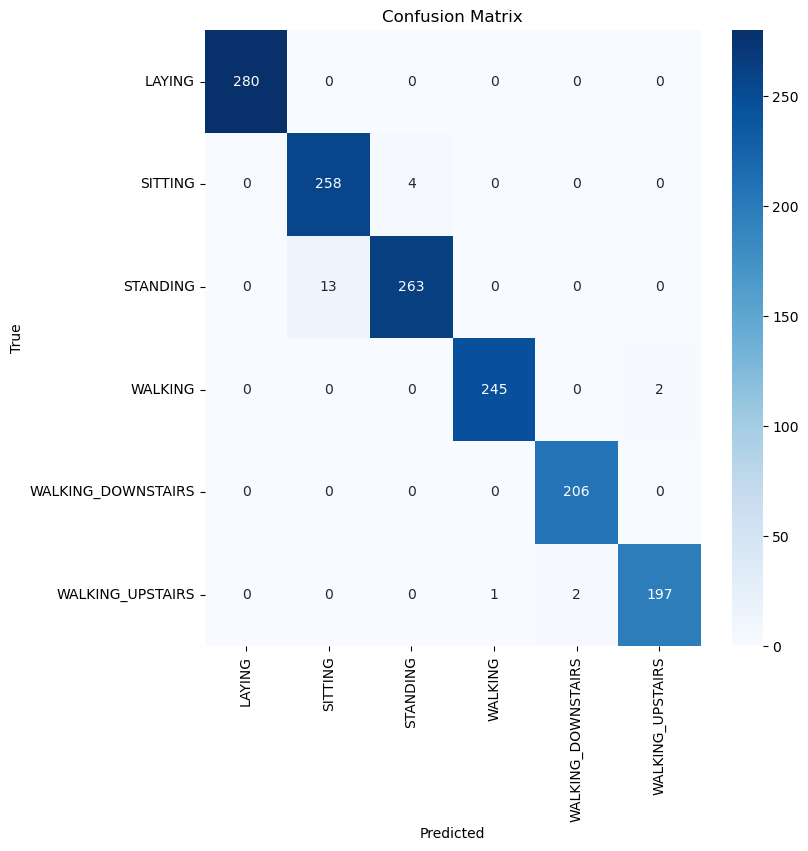

In [ ]:
# Evaluación en el conjunto de prueba
y_pred = np.argmax(model2.predict(X_test), axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

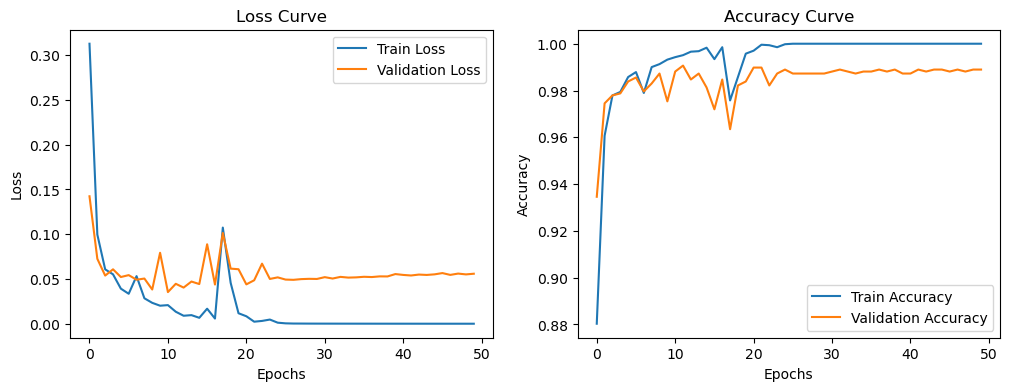

In [21]:
# Curvas de aprendizaje
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Sin la reduccion de dimensionalidad, el modelo es un poco menos estable, pero llega a un valor un poco mejor de precision del modelo, podriamos todavia probar algunas de las tecnicas de regularizacion para minimizar el overfitting.

Voy a validar los modelos con los datos contenidos en el archivo test.csv.

In [22]:
validacion = pd.read_csv('test.csv')
val_X_scaled = scaler.transform(validacion.drop('Activity', axis=1))
val_X_scaled_pca = pca_full.transform(val_X_scaled)
val_y = label_encoder.transform(validacion['Activity'])

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      0.97      0.98       537
           SITTING       0.96      0.87      0.91       491
          STANDING       0.87      0.96      0.91       532
           WALKING       0.92      0.98      0.95       496
WALKING_DOWNSTAIRS       0.97      0.91      0.94       420
  WALKING_UPSTAIRS       0.93      0.92      0.92       471

          accuracy                           0.94      2947
         macro avg       0.94      0.93      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



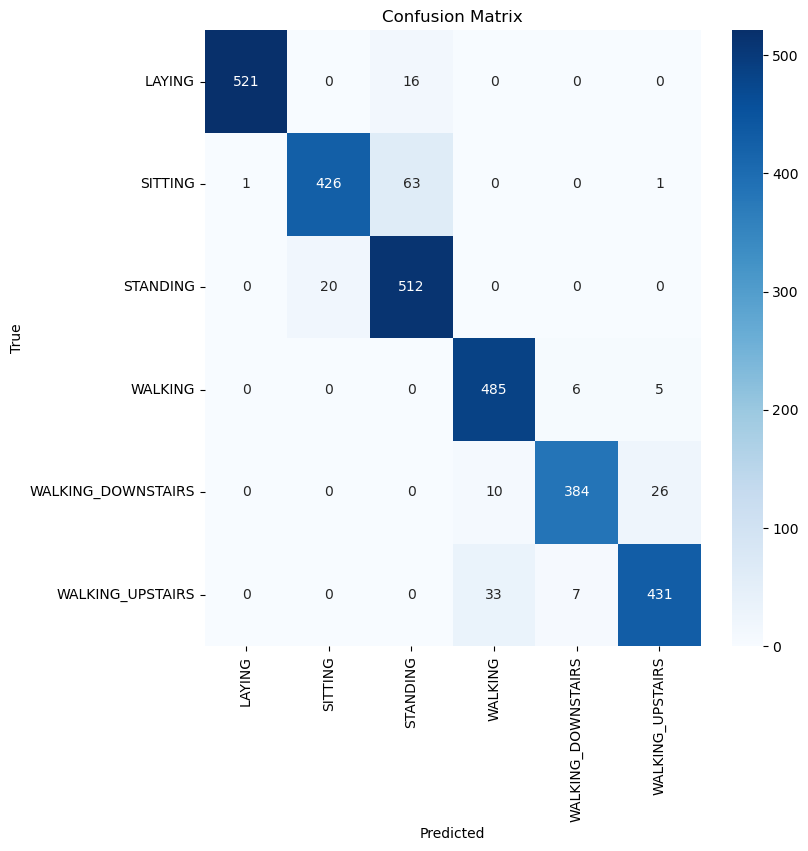

In [23]:
# Evaluación en el conjunto de validación
y_pred = np.argmax(model2.predict(val_X_scaled), axis=1)

print("SinPCA validacion:")
print(classification_report(val_y, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(val_y, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SinPCA')
plt.show()


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.94      0.85      0.89       491
          STANDING       0.86      0.95      0.90       532
           WALKING       0.92      0.98      0.95       496
WALKING_DOWNSTAIRS       0.93      0.89      0.91       420
  WALKING_UPSTAIRS       0.90      0.89      0.90       471

          accuracy                           0.92      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.92      0.92      2947



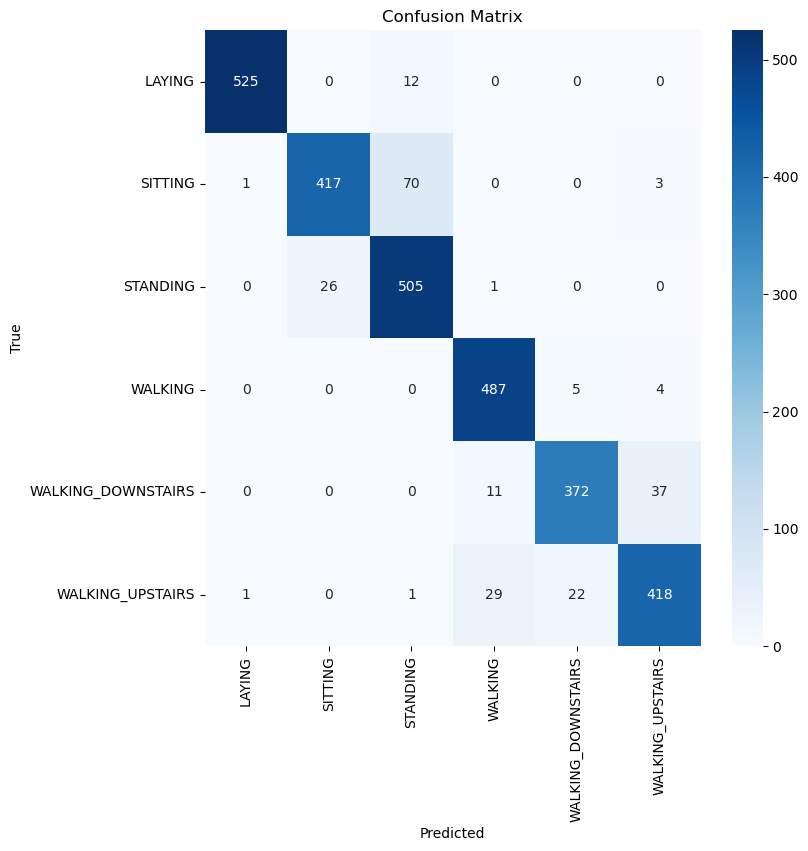

In [24]:
# Evaluación en el conjunto de validación
y_pred = np.argmax(model.predict(val_X_scaled_pca), axis=1)

print("ModeloPCA validacion:")
print(classification_report(val_y, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(val_y, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ModeloPCA')
plt.show()



#### Comparacion de los modelos en el Conjunto de Validacion

| **Activity**              | **ModeloPCA F1-Score** | **SinPCA F1-Score** | **Mejor Modelo** |
|---------------------------|---------------------|---------------------|------------------|
| **LAYING**                | 0.99               | 0.98               | ModeloPCA           |
| **SITTING**               | 0.89               | 0.91               | SinPCA            |
| **STANDING**              | 0.90               | 0.91               | SinPCA            |
| **WALKING**               | 0.95               | 0.95               | Empate              |
| **WALKING_DOWNSTAIRS**    | 0.91               | 0.94               | SinPCA            |
| **WALKING_UPSTAIRS**      | 0.90               | 0.92               | SinPCA            |

---

#### Macro and Weighted Averages

| **Metric**         | **ModeloPCA** | **SinPCA** |
|---------------------|------------|-----------|
| **Macro Average**   | 0.92       | 0.92      |
| **Weighted Average**| 0.92       | 0.93      |


Vemos que en la mayoria de las clases el Modelo sin la reduccion de Dimensionalidad se desempena un poco mejor, tanto en precision como en recall y F1-score, y en las clases mas faciles de distinguir como Walking o Laying es donde el desempeno de los dos modelos esta mas empatado.


Voy a probar un tercer modelo, sin el PCA donde voy a agregar capas de dropout despues de cada capa Dense, para reducir el overfitting que encontramos en los modelos anteriores

In [30]:
from tensorflow.keras.layers import Dropout
X = X_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Arquitectura del MLP
model3 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Primera capa oculta
    Dropout(0.5),  # Dropout después de la primera capa oculta (50% de las neuronas desactivadas)
    Dense(64, activation='relu'),  # Segunda capa oculta
    Dropout(0.3),  # Dropout después de la segunda capa oculta (30% de las neuronas desactivadas)
    Dense(6, activation='softmax')  # Capa de salida
])

# Compilación del modelo
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model3.summary()

/home/andy/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        72,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,710 (315.27 KB)

 Trainable params: 80,710 (315.27 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model3.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5578 - loss: 1.1097 - val_accuracy: 0.9184 - val_loss: 0.2135
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8599 - loss: 0.3508 - val_accuracy: 0.9541 - val_loss: 0.1202
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9039 - loss: 0.2380 - val_accuracy: 0.9635 - val_loss: 0.0951
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9080 - loss: 0.2339 - val_accuracy: 0.9745 - val_loss: 0.0714
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9339 - loss: 0.1751 - val_accuracy: 0.9609 - val_loss: 0.0947
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9446 - loss: 0.1470 - val_accuracy: 0.9762 - val_loss: 0.0577
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9474 - loss: 0.1323 - val_accuracy: 0.9805 - val_loss: 0.0616
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9481 - loss: 0.1292 - val_accuracy: 0.

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       280
           SITTING       0.95      0.95      0.95       262
          STANDING       0.95      0.96      0.95       276
           WALKING       1.00      1.00      1.00       247
WALKING_DOWNSTAIRS       1.00      1.00      1.00       206
  WALKING_UPSTAIRS       0.99      0.99      0.99       200

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



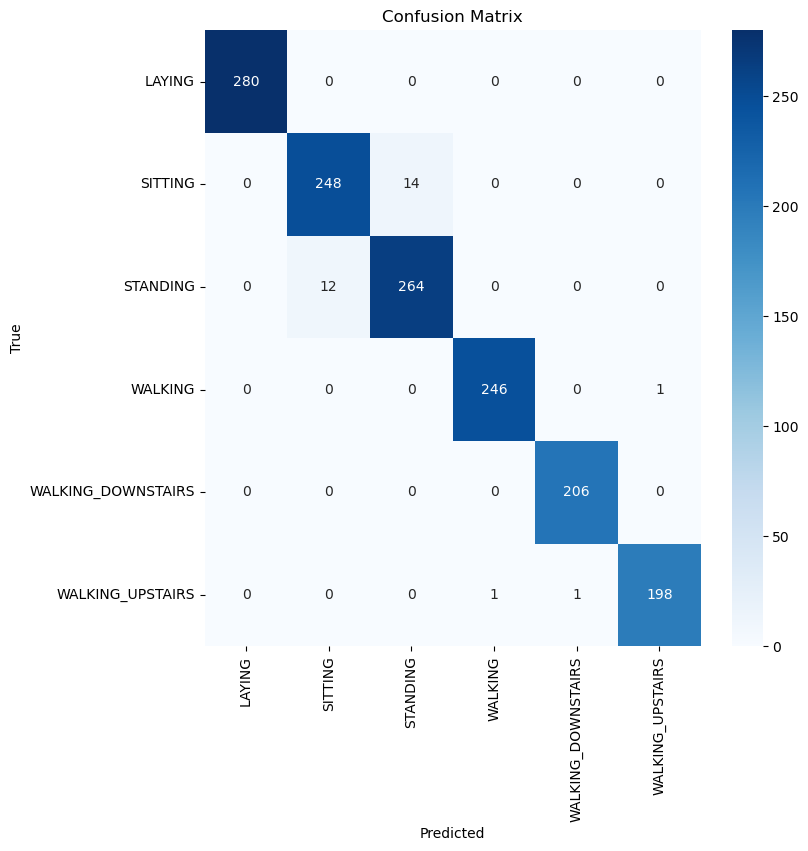

In [33]:
# Evaluación en el conjunto de prueba
y_pred = np.argmax(model3.predict(X_test), axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


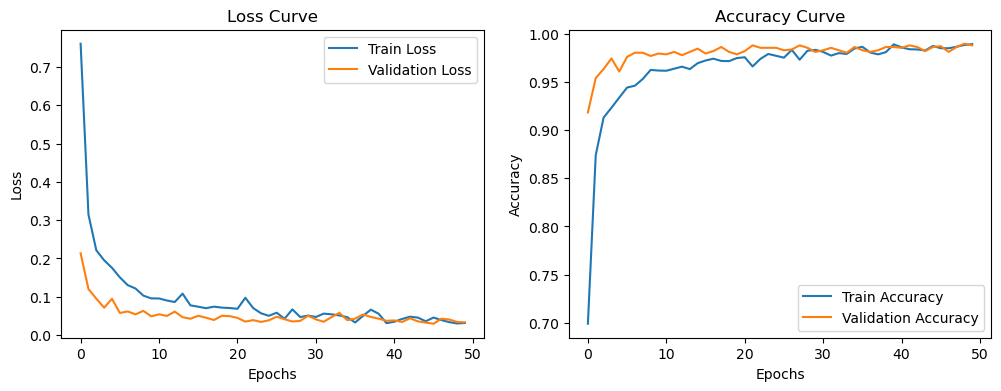

In [34]:
# Curvas de aprendizaje
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

Podemos ver que se redujo fuertemente el overfitting, y para una comparacion final del rendimiento, voy a evaluar el modelo con el archivo test.csv

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Dropout validacion:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.84      0.90       491
          STANDING       0.87      0.97      0.92       532
           WALKING       0.95      0.98      0.97       496
WALKING_DOWNSTAIRS       0.99      0.89      0.94       420
  WALKING_UPSTAIRS       0.92      0.97      0.95       471

          accuracy                           0.94      2947
         macro avg       0.95      0.94      0.94      2947
      weighted avg       0.95      0.94      0.94      2947



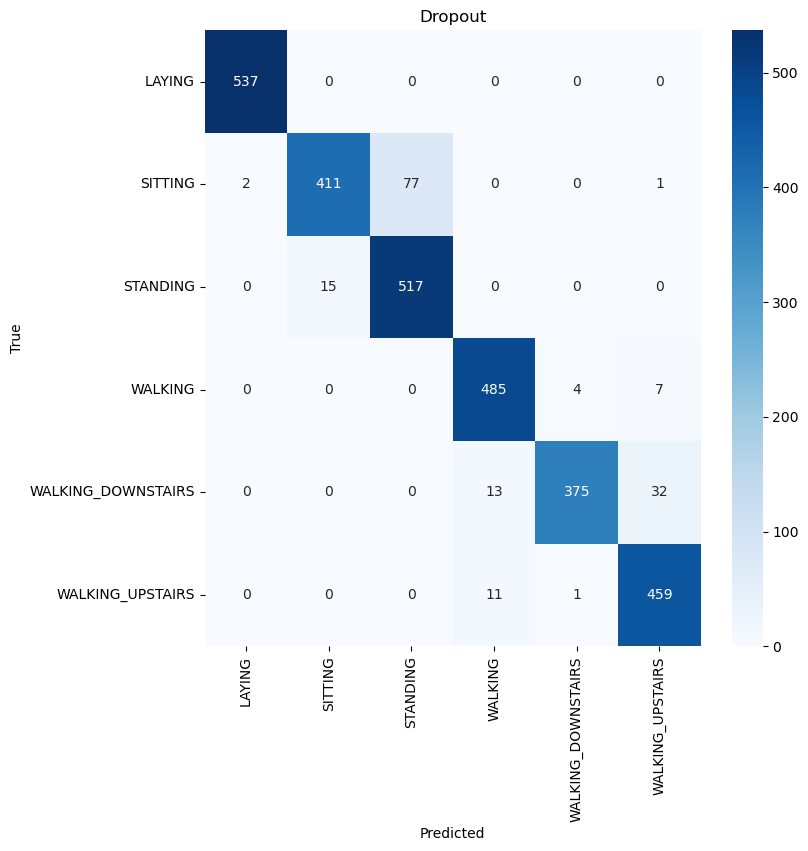

In [36]:
# Evaluación en el conjunto de validación
y_pred = np.argmax(model3.predict(val_X_scaled), axis=1)

print("Dropout validacion:")
print(classification_report(val_y, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(val_y, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Dropout')
plt.show()

| **Activity**           | **SinPCA (F1-Score)** | **Dropout Model (F1-Score)** | **Better Model**  |
|-------------------------|----------------------|------------------------------|-------------------|
| **LAYING**             | 0.98                | 1.00                        | Dropout Model     |
| **SITTING**            | 0.91                | 0.90                        | SinPCA             |
| **STANDING**           | 0.91                | 0.92                        | Dropout Model     |
| **WALKING**            | 0.95                | 0.97                        | Dropout Model     |
| **WALKING_DOWNSTAIRS** | 0.94                | 0.94                        | Empate             |
| **WALKING_UPSTAIRS**   | 0.92                | 0.95                        | Dropout Model     |

Podemos ver una mejora en la mayoria de las clases, a excepcion de sitting.


| **Metric**            | **SinPCA** | **Dropout Model** | **Better Model**  |
|------------------------|-----------|-------------------|-------------------|
| **Accuracy**          | 0.92      | 0.94              | Dropout Model     |
| **Macro Average (F1)**| 0.92      | 0.94              | Dropout Model     |
| **Weighted Average (F1)**| 0.93    | 0.94              | Dropout Model     |



5. Discusión y análisis:
- Reflexiona sobre los resultados del análisis no supervisado. ¿El análisis de clusters o PCA proporcionó insights útiles sobre las actividades? ¿Qué características son más importantes para clasificar las actividades físicas?
- Discute el rendimiento del MLP y cómo podría mejorarse. ¿Es adecuado este enfoque para predecir actividades basadas en datos sensoriales?

Con la reduccion de dimensionalidad pude ver que con tan solo 3 componentes principales ya se podia explicar mas del 60% de la variabilidad en los datos. 
Mientras que visualizar los datos en el espacio reducido de PCA me permitio ver como algunas actividades  forman grupos bien definidos, mientras que otras tienen mucho solapamiento, lo que nos indica que son mas similares y por lo tanto mas dificiles de distinguir.

El MLP mostro una buena capacidad de clasificacion, pero en los modelos iniciales un sobreajuste alto, que pudo corregirse introduciendo capas de Dropout, este podria seguir mejorandose mediante una optimizacion de hiperparametros, o adquiriendo datos complementarios.
Tambien se podria intentar modificar la arquitectura por mas capas/neuronas.